https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classifications

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators

import re



# Importando datos

In [94]:
# sample_sub= pd.read_csv(r'C:\Users\omarh\Documents\Tripleten\Proyectos_after_bootcamp\NLP\jigsaw_toxic_comment\data\sample_submission.csv')
# test = pd.read_csv(r'C:\Users\omarh\Documents\Tripleten\Proyectos_after_bootcamp\NLP\jigsaw_toxic_comment\data\test.csv')
# test_labels = pd.read_csv(r'C:\Users\omarh\Documents\Tripleten\Proyectos_after_bootcamp\NLP\jigsaw_toxic_comment\data\test_labels.csv')
# train = pd.read_csv(r'C:\Users\omarh\Documents\Tripleten\Proyectos_after_bootcamp\NLP\jigsaw_toxic_comment\data\train.csv')


sample_sub= pd.read_csv(r'C:\Users\ramos\Documents\Tripleten\Proyectos_after_bootcamp\NLP\jigsaw_toxic\data\sample_submission.csv')
test = pd.read_csv(r'C:\Users\ramos\Documents\Tripleten\Proyectos_after_bootcamp\NLP\jigsaw_toxic\data\test.csv')
test_labels = pd.read_csv(r'C:\Users\ramos\Documents\Tripleten\Proyectos_after_bootcamp\NLP\jigsaw_toxic\data\test_labels.csv')
train = pd.read_csv(r'C:\Users\ramos\Documents\Tripleten\Proyectos_after_bootcamp\NLP\jigsaw_toxic\data\train.csv')





**Descripción de los archivos:**
* **train.csv** - Set de entrenamiento, contiene comentarios con sus etiquetas binarias
* **test.csv** - Set de prueba, vamos a predecir las probabilidades de clase para la toxicidad de estos comentarios.
* **sample_submission.csv** un ejemplo de archivo de presentación en el formato correcto
* **test_labels.csv** etiquetas para los datos de prueba; valor de **-1** indica que no fue usado para la evaluación

In [95]:
test['comment_text'].iloc[10]

'I think its crap that the link to roggenbier is to this article. Somebody that knows how to do things should change it.'

# EDA

## Exploring data and columns

**En el dataset tenemos un gran número de comentarios extraidos de Wikipedia que fueron etiquetado por humanos para comportamiento tóxico, los timpos de toxicidad son:**

* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

In [96]:
train[train.id=='f9b25ccdab72e094']['comment_text'].iloc[0]

'"\n\nAnd western reports are? You\'re a biased fuck. So, the US, UK, or France can claim whatever casualties they want... thats fine, but when Libya claims to have caused casuatlies you immediately lable it ""unreliable"" and remove it? Your bias is showing asswipe... cover it up before you stain Wikipedia\'s name even more.- AGSman61"'

In [97]:
display(train.info())
display(train.describe())
display(train.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


None

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [98]:
len(train)

159571

In [99]:
#Verifying class imbalance

toxic = int(train[train['toxic']==1]['toxic'].sum().astype(int)) * 100 / len(train['toxic'])
severe_toxic = int(train[train['severe_toxic']==1]['severe_toxic'].sum().astype(int)) * 100 / len(train)
obscene = int(train[train['obscene']==1]['obscene'].sum().astype(int)) * 100 / len(train)
threat = int(train[train['threat']==1]['threat'].sum().astype(int)) * 100 / len(train)
insult = int(train[train['insult']==1]['insult'].sum().astype(int)) * 100 / len(train)
identity_hate = int(train[train['identity_hate']==1]['identity_hate'].sum().astype(int)) * 100 / len(train)

# non_labeled = int(train[train['identity_hate']==0]['identity_hate'].sum().astype(int)) * 100 / len(train)






col_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [100]:
all_one = len(train[train[col_labels].all(axis=1)])
any_one = train[train[col_labels].any(axis=1)]
all_zero = len(train[~train[col_labels].any(axis=1)])
mixed = len(train[train[col_labels].any(axis=1) & ~train[col_labels].all(axis=1)]) #any_one

len(train) - (all_one + all_zero + mixed )

0

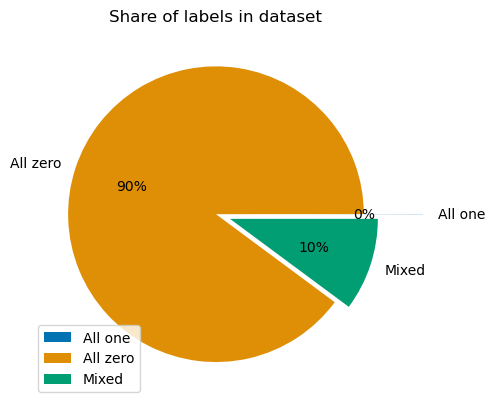

In [101]:
sizes = [all_one, all_zero, mixed]
labels = ['All one','All zero', 'Mixed']
explode = [0.4,0,0.1]

colors = sns.color_palette('colorblind')

plt.pie(sizes, labels = labels, explode = explode, autopct='%0.f%%', colors=colors)
plt.title('Share of labels in dataset')
plt.legend(loc=3)


In [102]:
print(f'There are {all_one} instances where all labels are set to 1, representing less than 0.01% of the data')
print(f'There are {mixed} instances where at least one label is set to 1, representing 10% of the data')
print(f'There are {all_zero} instances where all labels are set to 1, representing 90% of the data')

There are 31 instances where all labels are set to 1, representing less than 0.01% of the data
There are 16194 instances where at least one label is set to 1, representing 10% of the data
There are 143346 instances where all labels are set to 1, representing 90% of the data


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

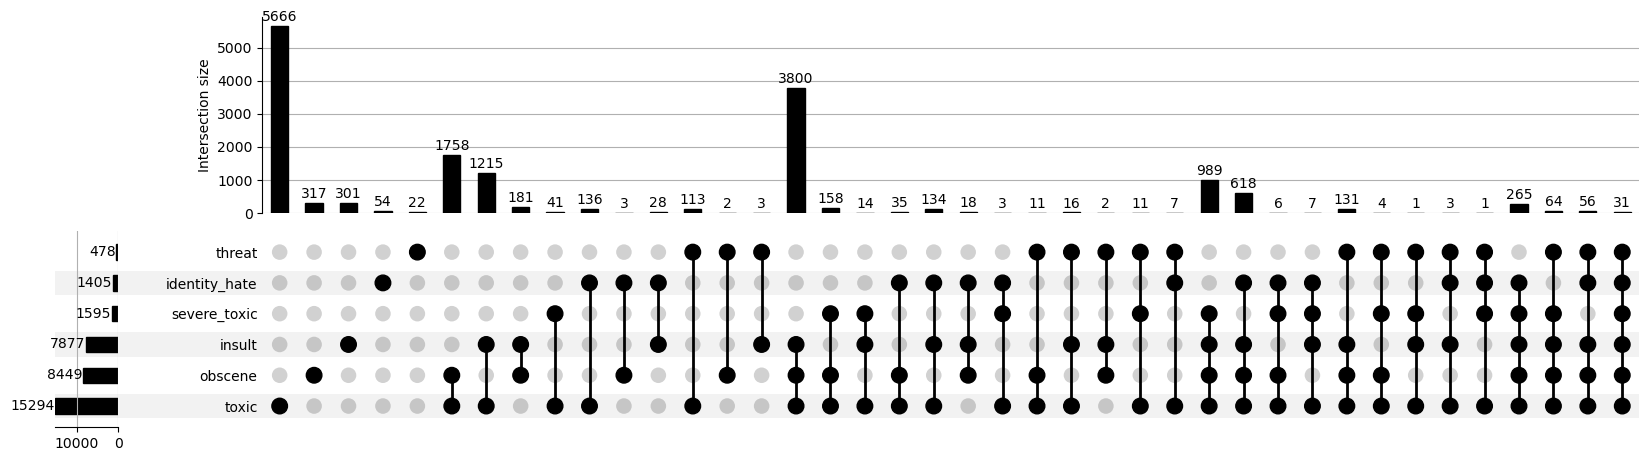

In [103]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='upsetplot')
data = from_indicators(col_labels, any_one[col_labels].astype(bool))
UpSet(data, show_counts=True).plot()

**We can observe:**
* Most toxic comments contain only the **toxic** label, indicating mild or generic toxicity (5,666 instances).
* The most frequent label overall is **toxic**, appearing in 15,294 instances.
* **obscene** and **insult** are rarely present as standalone labels (fewer than 320 instances each). However, when combined with other labels, they appear in 8,449 and 7,887 instances, respectively.
* **severe_toxic** does not appear as a standalone label. Instead, it only occurs in combination with other labels (1,595 instances).
    * This is relevant because it indicates that *severe_toxic* is a dependent label
* **identity_hate** has very few standalone instances (54), but appears in combination with other labels in 1,405 instances.
* **threat** is the least common label in the dataset, with only 22 standalone instances and 478 instances when combined with other labels.

# Data Preprocessing

In [104]:
train['comment_text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [105]:
# train['comment_text'].iloc[5]

In [106]:
train['comment_text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [107]:
train['comment_text'].loc[7330]

'_________________________________________________________________________________________________________________________________________\n\n            Towards Futuristic Economics?\n\nThere is a new paradigm slowly emerging of great importance.It also solves many of the problems in economics, and represents a great breakthrough for Global Justice.\n\n     http://www.p2pfoundation.net/Transfinancial_Economics\n\n____________________________________________________________________'

In [108]:
#Replacing URLs for tokens 
train['comment_text'] = train['comment_text'].str.replace(
    r'(https?://\S+|www\.\S+)',' URL ',regex=True)

# train['comment_text'] = train['comment_text'].str.replace(r'(http?://\S+www.\.\S+)',' URL ',regex=True)

#Replacing line breaks / tabs for single space
train['comment_text'] = train['comment_text'].str.replace(r'[\n\r\t]+',' ', regex=True)

#Replacing multiple Quotation  marks to one
train['comment_text'] = train['comment_text'].str.replace(r'(["])\1+', r'\1', regex=True)

#Replacing multiple marks to max 3 
train['comment_text'] = train['comment_text'].str.replace(r'([_\-=*~!?\.:\;,])\1{3,}', r'\1\1\1', regex=True)

#Replacing multiple spaces to 1 
train['comment_text'] = train['comment_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [109]:
train['comment_text'].loc[7330]

'___ Towards Futuristic Economics? There is a new paradigm slowly emerging of great importance.It also solves many of the problems in economics, and represents a great breakthrough for Global Justice. URL ___'

In [35]:
train['comment_text'].str.replace(r'([":])\1+',r'\1', regex=True).str.replace(r'[\n\r\t]', ' ', regex=True).str.replace(r'\s+',' ',regex=True)




0         Explanation Why the edits made under my userna...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         " More I can't make any real suggestions on im...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":And for the second time of asking, when your...
159567    You should be ashamed of yourself That is a ho...
159568    Spitzer Umm, theres no actual article for pros...
159569    And it looks like it was actually you who put ...
159570    " And ... I really don't think you understand....
Name: comment_text, Length: 159571, dtype: object

In [51]:
#Realizando pruebas
dftest = train.copy()

dftest['comment_text']= dftest['comment_text'].str.replace(r'[\n\r\t]', ' ', regex=True)

mask = dftest['comment_text'].str.contains(r'([":!*?-_])\1{2,}', regex=True)
dftest[mask]

C:\Users\ramos\AppData\Local\Temp\ipykernel_70868\365901509.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = dftest['comment_text'].str.contains(r'([":!*?-_])\1{2,}', regex=True)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_norm
49,001d874a4d3e8813,"""::::Jmabel; in regards to predominant scholar...",0,0,0,0,0,0,jmabel in regards to predominant scholary cons...
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,get fucked up get fuckeeed up got a drink that...
59,002264ea4d5f2887,Why can't you believe how fat Artie is? Did yo...,1,0,0,0,0,0,why can t you believe how fat artie is did you...
175,006b888560bcdfcd,"""know the sex of the foetus""""""",0,0,0,0,0,0,know the sex of the foetus
206,0082b5a7b4a67da2,Give me a permanat block raseac....!!! remembe...,1,0,0,0,0,0,give me a permanat block raseac remember me mu...
...,...,...,...,...,...,...,...,...,...
159424,fd6d21dae65d9cb1,""":::::What's meaningless is your POV argument....",0,0,0,0,0,0,what s meaningless is your pov argument the mo...
159449,fdce660ddcd6d7ca,I think he is a gay fag!!!,1,0,0,0,0,1,i think he is a gay fag
159534,ff7ec72ecc73f589,""" Thanks. It looks like Mr. Case is done for t...",0,0,0,0,0,0,thanks it looks like mr case is done for the d...
159546,ffb47123b2d82762,""" Hey listen don't you ever!!!! Delete my edi...",1,0,0,0,1,0,hey listen don t you ever delete my edits ever...


truncar URLS y comentarios basura (ta bueno el bisne)

In [50]:
dftest.loc[7330]['comment_text']

'_________________________________________________________________________________________________________________________________________              Towards Futuristic Economics?  There is a new paradigm slowly emerging of great importance.It also solves many of the problems in economics, and represents a great breakthrough for Global Justice.       http://www.p2pfoundation.net/Transfinancial_Economics  ____________________________________________________________________'

In [ ]:
r'([:!?\*])\1+','r\1\1\1'

In [ ]:
#Normalizing columns for BERT
#Creating regex pattern to eliminate line breaks and 
pattern = r'[]'

In [27]:
train['comment_text'].loc[159566    ]

'":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can\'t even give a consistent argument - is the opening only supposed to mention significant aspects, or the ""most significant"" ones?   \n\n"'

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [ ]:
# normalizing columns for possible NLTK model
#Creating regex pattern to eliminate punctuation marks and digits
pattern= r'[^a-zA-Z]'
#Applying pattern through lambda and collapsing all spaces into one
train['comment_norm'] = (train['comment_text'].str.replace(pattern,' ', regex=True)
                         .str.lower()
                         .str.strip()
                         .str.replace(r'\s+',' ',regex=True))

# train['comment_text'].apply(lambda x : re.sub(pattern, ' ', x).strip().lower()  ).apply(lambda x : re.sub(r'\s+', ' ', x))

train['comment_norm']


0         explanation why the edits made under my userna...
1         d aww he matches this background colour i m se...
2         hey man i m really not trying to edit war it s...
3         more i can t make any real suggestions on impr...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm theres no actual article for prost...
159569    and it looks like it was actually you who put ...
159570    and i really don t think you understand i came...
Name: comment_norm, Length: 159571, dtype: object